# Librairies et fonctions

In [1]:
##############################################################################################################################################
##############################                                                                                   #############################
##############################                                        European Climate Assessment  &             #############################
##############################                                                 Eurostat                          #############################
##############################                                             Updated 14/11/22                      #############################
##############################################################################################################################################

###  librairies declaration
import warnings
import time
import pandas                             as pd
#import duckdb                             as db
import missingno                          as missin
import os

import numpy                              as np
lasource_de_donnees="Sources : European Climate Assessment & Dataset (ECAD) & Eurostat urb-cpop - Updated 14/11/22"
import plotly.express                     as px
import plotly.graph_objects               as go

from math import *
import scipy.stats                        as st

# Analyse de la normalité grâce au test de shapiro
from scipy.stats import shapiro, pearsonr, spearmanr, kendalltau

# Missing value
import missingno                          as msno # msno.bar(le_df) ou matrix(le_df) ou heatmap(le_df)

from scipy.stats                          import chi2_contingency #from scipy.stats import chi2_contingency
from sklearn.cluster                      import KMeans
import seaborn                            as sns; sns.set()

import matplotlib.pyplot                  as plt
#import seaborn            as sns

import statsmodels.api                    as sm
import statsmodels.formula.api            as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn                              import preprocessing,cluster,decomposition,metrics  # normalisation

# Function biplot :
import matplotlib                         as mpl
import matplotlib.cm                      as cm
from scipy.spatial                        import ConvexHull

# Normaliser les donnees :
from sklearn.preprocessing                import StandardScaler

warnings.filterwarnings('ignore')

# Set max rows displayed for readability
#pd.set_option("display.max_rows", 23)
# Configure display options
pd.set_option("display.max_columns", None)

def calculer_plage_max(var_x,var_y,df):
    '''
    Allows you to establish the maximum range without interruption or there is a lot of data (temperatures, number of cities, etc.)
    '''
    x=df[var_x];y=df[var_y]-df[var_y].quantile(0.50)
    # Identifier les points où la courbe traverse l'axe des abscisses
    points_intersection = np.where(y >= 0)[0]
    # Initialise debut /fin de segement
    debut_segment = 0; fin_segment = 0;sav_plage_max=0; sav_debut_segment=0;sav_fin_segement=0; plage_max=0;iteration=0

    # il faut trouver le plus long segement
    for i in range(len(points_intersection) - 1):
        #print("1ere i ",i)
        if debut_segment ==0 & iteration== 0:
            debut_segment = points_intersection[i]
            iteration=points_intersection[i]+1            
        else:
            if iteration==points_intersection[i]:
                plage_max = points_intersection[i]-debut_segment
                fin_segment=points_intersection[i]
                iteration=points_intersection[i]+1 
            else:
                # save plage max 
                if plage_max>sav_plage_max:
                    sav_plage_max=plage_max
                    sav_debut_segment=debut_segment
                    sav_fin_segment=fin_segment
                iteration=points_intersection[i]+1  
                debut_segment=points_intersection[i]
                plage_max=0
                
    return var_y,df.iloc[sav_debut_segment,0],df.iloc[sav_fin_segment,0]


strdirectory="Analyse Temperature Europe/..."

# Open Files de fichier

In [2]:
# Fichier à ouvrir
fichier=pd.read_csv(strdirectory+'Selection_etape_2_data_temps_hab.csv')

fichier['DATE_str_YEAR']=fichier['DATE_str_YEAR'].astype(str)
fichier['DATE_str_MONTH']=fichier['DATE_str_MONTH'].astype(str)
fichier['DATE_str_DAY']=fichier['DATE_str_DAY'].astype(str)

# Categorie - Creation de classe

In [14]:

def renommer_et_presentation_categorie(df,la_classe_colonne,la_colonne,nombre_categorie,la_precision=0):
    '''
    Permet  de discretiser , de renommer, et d'ordonner les nouvelles colonnes categorielles
    '''
    # decoupage de la_colonne en nombre_categorie => categorie +> discretisation en quantiles egaux 
    df[la_classe_colonne]=pd.qcut(df[la_colonne],nombre_categorie, precision=la_precision)
    # je recupère dans une variable de type Serie l'ensemble des quantiles et leur nombre
    comptages = df[la_classe_colonne].value_counts()
    # Initialisation
    liste_triee=[]
    liste_composee=[]
    list=[]
    category_names={} 
    i=0
    
    # Parcourir les valeurs et leurs comptages
    for valeur, comptage in comptages.items():
        borne_inf=valeur.left
        borne_sup=valeur.right
        intervalle="]"+"{:,.0f}".format(float(str(borne_inf).replace('.0',''))).replace(",", " ")+","+"{:,.0f}".format(float(str(borne_sup).replace('.0',''))).replace(",", " ")+"]"
        liste_composee.append([borne_inf,intervalle])
        #list.append("]"+"{:,.0f}".format(float(str(valeur.left).replace('.0',''))).replace(",", " ")+","+"{:,.0f}".format(float(str(valeur.right).replace('.0',''))).replace(",", " ")+"]")
        #category_names[df[la_classe_colonne].unique()[i]]=list[i]
        i=i+1
    # Je trie 
    i=0
    liste_triee = sorted(liste_composee, key=lambda x: x[0])
    for item in liste_triee:
        category_names[df[la_classe_colonne].unique()[i]]=liste_triee[i][1]
        list.append(liste_triee[i][1])
        i=i+1
        
    df[la_classe_colonne] = df[la_classe_colonne].map(category_names)
    
    return list        
        

In [18]:
# Je regroupe les données sur l'ensemble des années
df_extract_with_classes=fichier.groupby(['CITY','CN','CN_NAME','CAPITALE','LAT_degre','LON_degre',
                                        'HGHT_num'],as_index=False).agg({'TEMPERATURE':'mean','NB_HAB':'mean'})
order_dict={}
order_HAB=[]
order_LAT=[]
order_LON=[]
order_TEM=[]
order_HGH=[]

##########################################              CLASSES         ################################################
# Pour chaque colonne, je discretise et je garde l'ordre des classes créées dabs order_***
order_HAB=renommer_et_presentation_categorie (df_extract_with_classes,'classe_HAB','NB_HAB',3)
order_dict['classe_HAB']=order_HAB

order_LAT=renommer_et_presentation_categorie (df_extract_with_classes,'classe_LAT_degre','LAT_degre',3)
order_dict['classe_LAT_degre']=order_LAT

order_LON=renommer_et_presentation_categorie (df_extract_with_classes,'classe_LON_degre','LON_degre',3)
order_dict['classe_LON_degre']=order_LON

order_TEM=renommer_et_presentation_categorie (df_extract_with_classes,'classe_TEMPERATURE','TEMPERATURE',2)
order_dict['classe_TEMPERATURE']=order_TEM

order_HGH=renommer_et_presentation_categorie (df_extract_with_classes,'classe_HGHT_num','HGHT_num',4)
order_dict['classe_HGHT_num']=order_HGH

#

# Analyse univariée

## Résumé

In [19]:
df_extract_with_classes.describe(include='all')

,CITY,CN,CN_NAME,CAPITALE,LAT_degre,LON_degre,HGHT_num,TEMPERATURE,NB_HAB,classe_HAB,classe_LAT_degre,classe_LON_degre,classe_TEMPERATURE,classe_HGHT_num
count,65,65,65,65,65.000000,65.000000,65.000000,65.000000,6.500000e+01,65,65,65,65,65
unique,65,8,8,2,NaN,NaN,NaN,NaN,NaN,3,3,3,2,4
top,A CORUNA,DE,Allemagne,N,NaN,NaN,NaN,NaN,NaN,"]229 607,3 443 890]","]37,48]","]-9,8]","]15,25]","]285,735]"
freq,1,40,40,61,NaN,NaN,NaN,NaN,NaN,22,22,22,33,17
mean,NaN,NaN,NaN,NaN,49.360728,9.043300,170.657114,15.568101,2.817166e+05,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,4.815174,7.559797,178.201312,3.113220,4.669093e+05,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,37.926830,-7.604400,1.000000,9.976512,5.528166e+04,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,47.490300,7.270600,37.000000,13.607248,8.980144e+04,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,49.771400,9.952800,96.000000,14.769724,1.646118e+05,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,52.463900,12.131700,285.000000,17.476458,2.730370e+05,NaN,NaN,NaN,NaN,NaN


## Variable Quantative

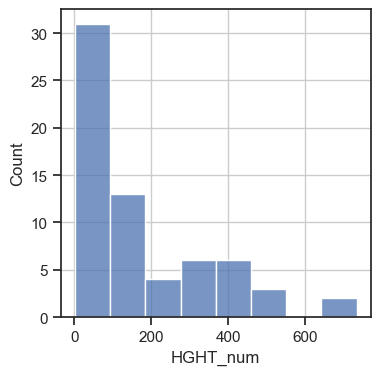

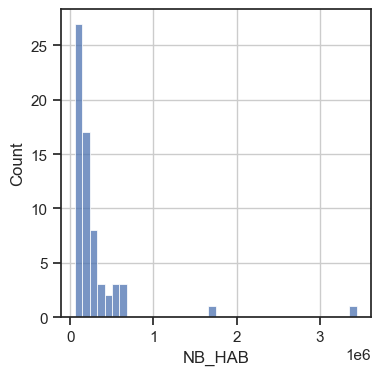

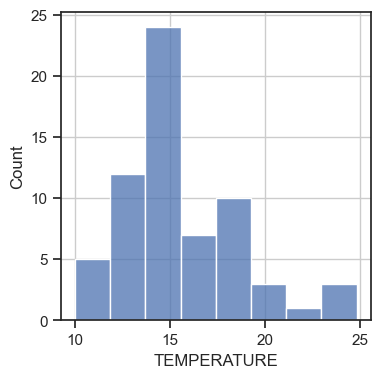

In [20]:
# Selection de variable quantitative +City
quant_vars = df_extract_with_classes[['classe_LAT_degre','HGHT_num','NB_HAB','TEMPERATURE']]

axe_abscisse=4
axe_ordonnee=4

# Plotting boxplots for each quantitative variable with Seaborn
sns.set(style="ticks")

for var in quant_vars:
    if var!='classe_LAT_degre':
        plt.figure(figsize=(axe_abscisse,axe_ordonnee))
        plt.grid()
        sns.histplot(data=df_extract_with_classes, x=var)

Une première analyse visuelle nous conduit à penser qu'il n'y a aucune distribution normale.

Vérification par le test de Shapiro-Wilk

Distribution Normale - Test de Shapiro


H0 : La distribution est normale

H1 : La distribution n'est pas normale

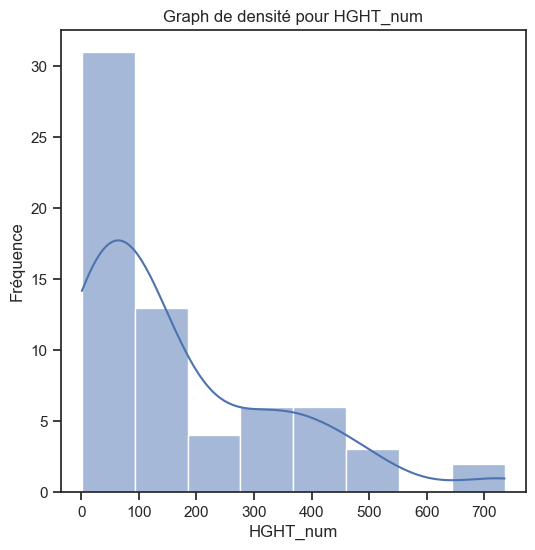

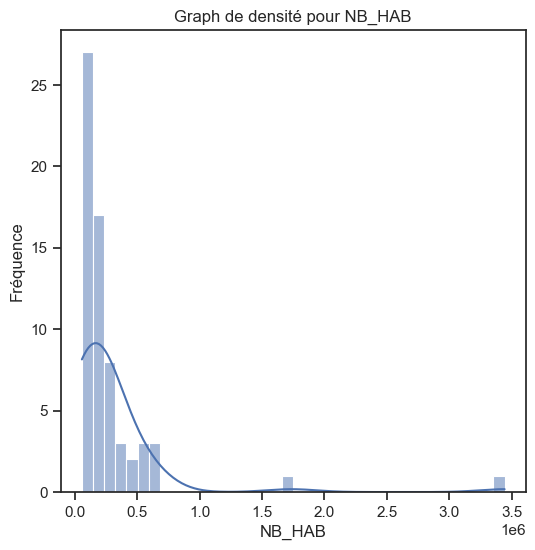

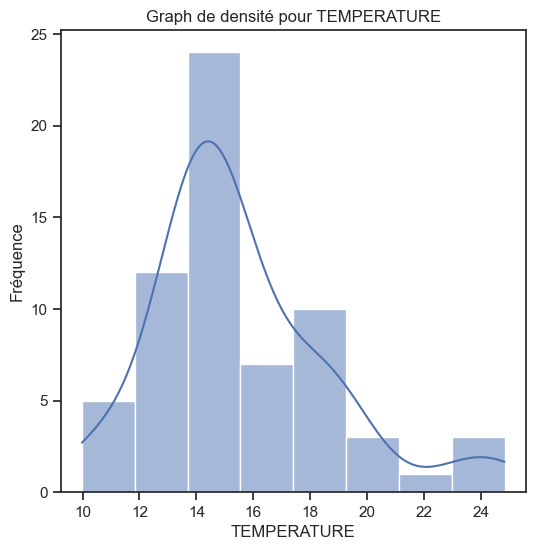

H0 : Distribution normale
H1 : Distribution pas normale

------------------------------------------------------
Variable HGHT_num
P-valeur de  Shapiro-Wilk : 4.196712382054102e-07
Rejet H0, la distribution n'est pas  normale
------------------------------------------------------
Variable NB_HAB
P-valeur de  Shapiro-Wilk : 1.160002473308934e-14
Rejet H0, la distribution n'est pas  normale
------------------------------------------------------
Variable TEMPERATURE
P-valeur de  Shapiro-Wilk : 0.0001724349713185802
Rejet H0, la distribution n'est pas  normale


In [21]:
# Test de SHapiro-Wilk
from scipy.stats import shapiro, pearsonr, spearmanr, kendalltau
# Variables quantitatives d'intérêt
quant_vars = df_extract_with_classes[['HGHT_num','NB_HAB','TEMPERATURE']]

# Analyse graphique de la normalité des deux variables
for var in quant_vars:
    plt.figure(figsize=(6, 6))
    sns.histplot(df_extract_with_classes[var], kde=True)
    plt.xlabel(var)
    plt.ylabel('Fréquence')
    plt.title(f"Graph de densité pour {var}")
    plt.show()

# Check for normality using the Shapiro-Wilk test
print("H0 : Distribution normale") 
print("H1 : Distribution pas normale") 
print("")
for var in quant_vars:
    print("------------------------------------------------------")
    print("Variable",var)
    _, p_value = shapiro(df_extract_with_classes[var])
    print("P-valeur de  Shapiro-Wilk :", p_value)
    if p_value<0.05:
        print("Rejet H0, la distribution n'est pas  normale")
    else:
        print("La distribution est normale")
    

## Variable Qualitative

HGHT_num n° 1
nb outlier


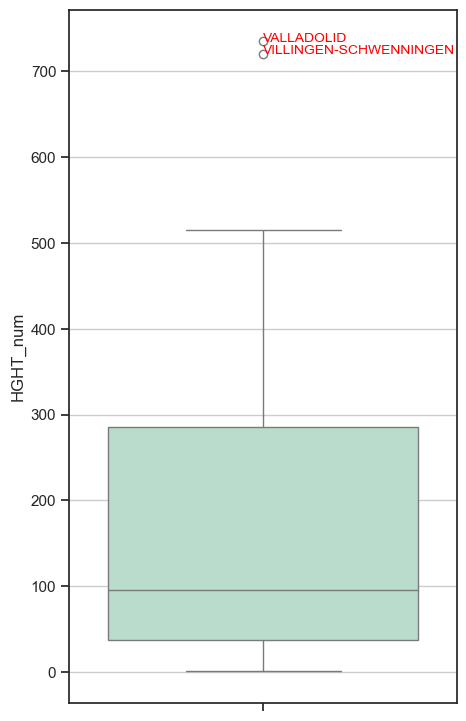

NB_HAB n° 2
nb outlier


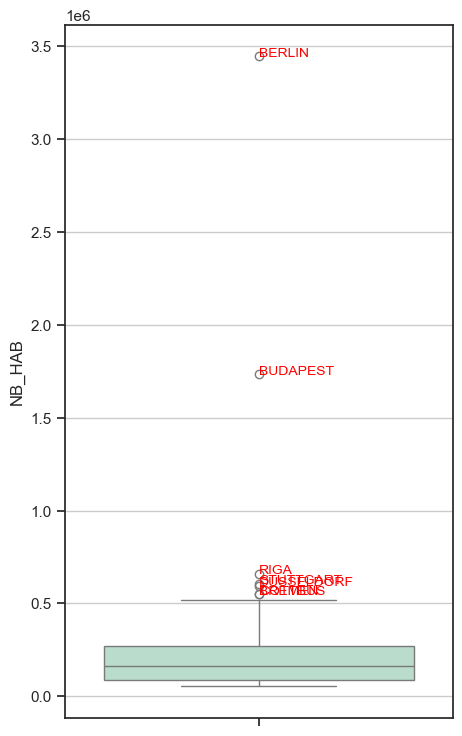

TEMPERATURE n° 3
nb outlier


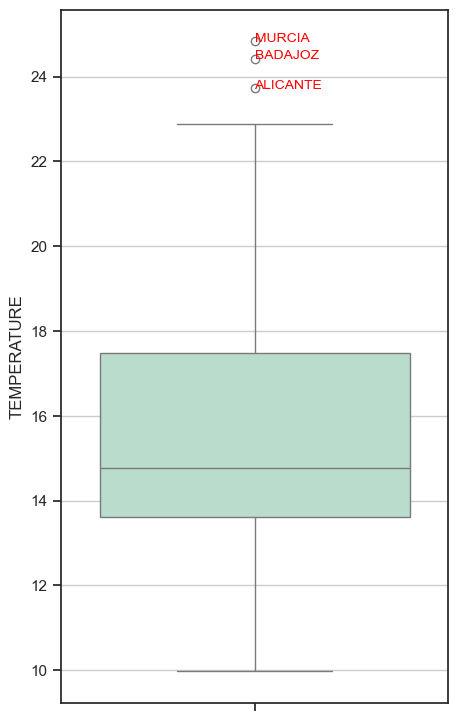

In [22]:
# Selection of quantitative variables + 'CITY'
quant_vars = df_extract_with_classes[['CITY','HGHT_num','NB_HAB','TEMPERATURE']] #.select_dtypes(include=['float64', 'int64'])  .query("CN!='DE' & CN!='ES' & CN!='PL' & CN!='RO'")

axe_abscisse=5
axe_ordonnee=9
# Plotting boxplots for each quantitative variable with Seaborn
sns.set(style="ticks")
enumere=0
for var in quant_vars:
    if var!='CITY': #if var!='LAT_degre' and var!='LON_degre' and var!='CITY':
        enumere=enumere+1
        print(var,"n°",enumere)
        # mediane ?
        la_mediane=quant_vars[var].median()
        plt.figure(figsize=(axe_abscisse,axe_ordonnee))
        plt.grid()
        box=sns.boxplot(y=var, data=quant_vars, palette="Pastel2" )
        #box=sns.stripplot( y=var,data=quant_vars)
        # Identify the upper and lower bound outliers:
        delta= 1.5*(quant_vars[var].quantile(0.75) - quant_vars[var].quantile(0.25))
        outliers = quant_vars[(quant_vars[var] > (quant_vars[var].quantile(0.75) + delta)) | (quant_vars[var] < (quant_vars[var].quantile(0.25) - delta))]
        # Ajoutez les annotations
        for i, outlier in outliers.iterrows():
          box.annotate(str(outlier["CITY"]), xy=(0, outlier[var]), color="red", fontsize=10)

        quant_vars['col_zscore'] = (quant_vars[var] - quant_vars[var].mean())/quant_vars[var].std(ddof=0)
        print("nb outlier",)

        plt.show()

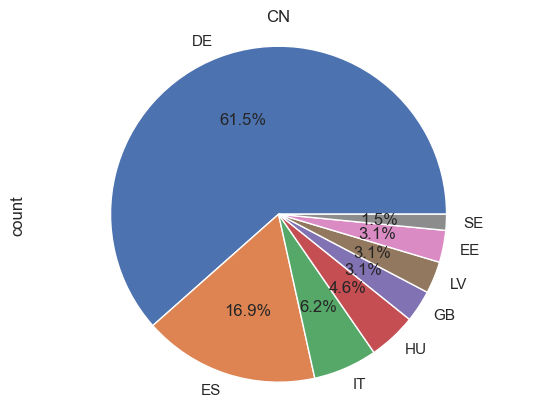

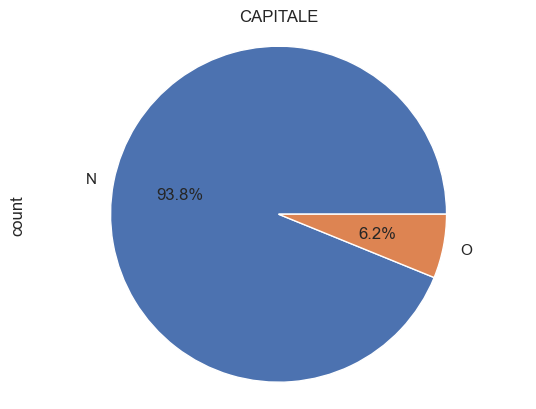

In [23]:

cat_vars = ['CN','CAPITALE']
#fichier_analyser_sans_pays_PL = fichier_analyser.query("CN!='DE' & CN!='ES' & CN!='PL' & CN!='RO'")

# Generate a pie plot for each categorical variable
for var in cat_vars:
    df_extract_with_classes[var].value_counts().plot(kind='pie', autopct='%1.1f%%')
    plt.title(var)
    plt.axis('equal')
    plt.show()

# Analyse Bivariée

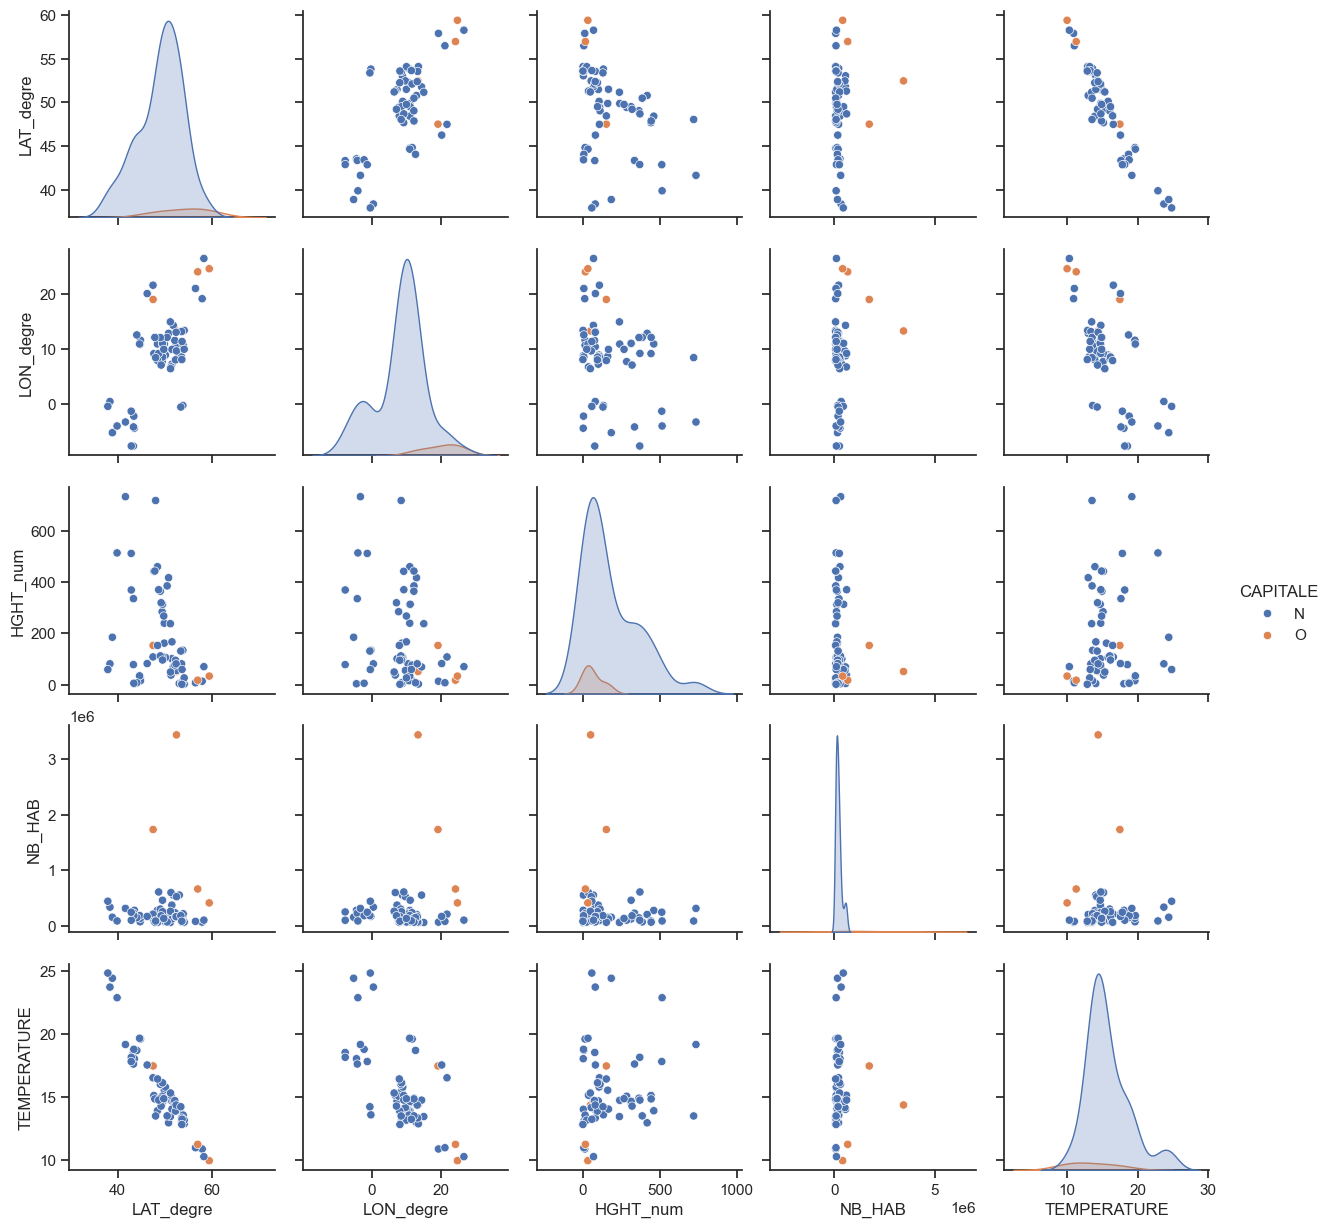

In [24]:
sns.pairplot(fichier.groupby(['CITY',
      'CN','CN_NAME','CAPITALE'],as_index=False).agg({'LAT_degre':'mean',	'LON_degre':'mean',	'HGHT_num':'mean',	'NB_HAB':'mean',	'TEMPERATURE':'mean'}),hue='CAPITALE')

Analyse Visuelle :

Il apparait une relation linéaire entre la LATITUDE et la TEMPERATURE

## Quanti vs Quali

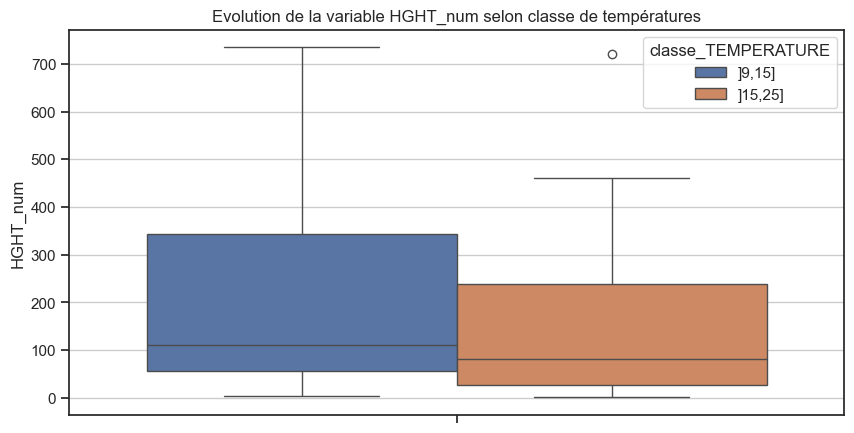

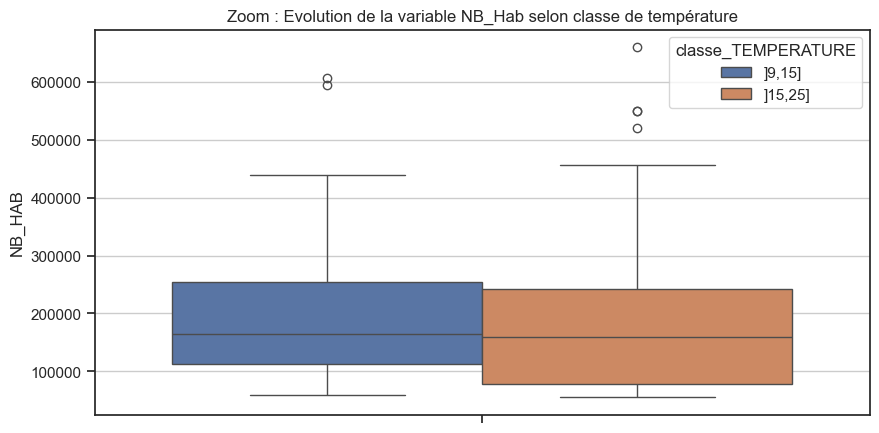

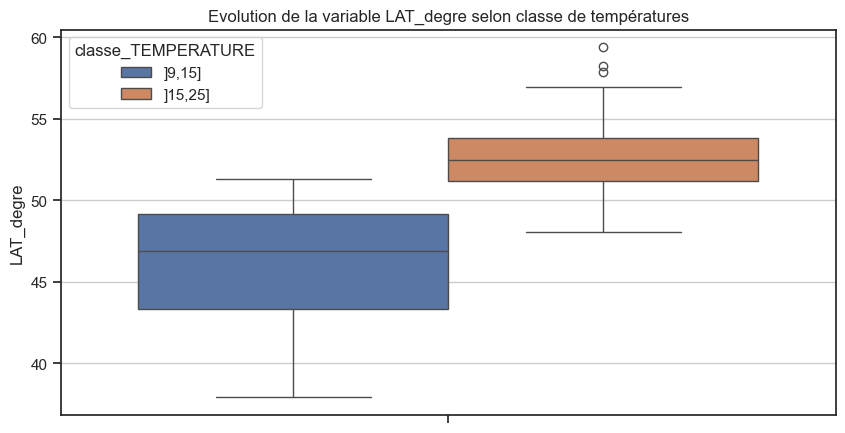

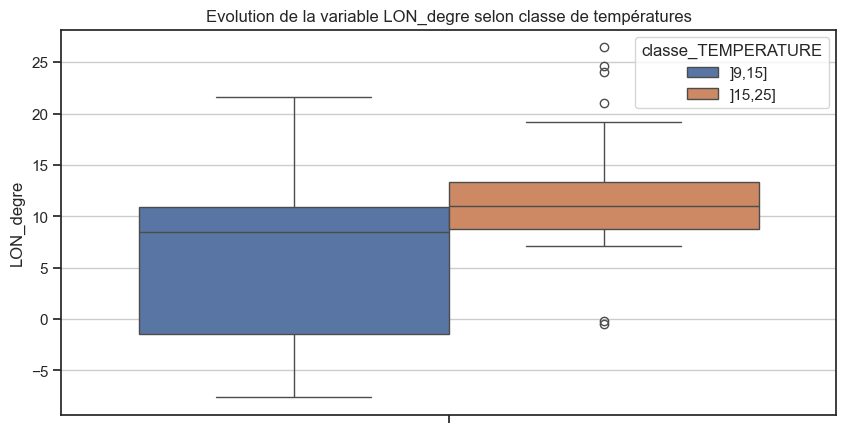

In [25]:
# Selection of quantitative variables+Citye
quant_vars = df_extract_with_classes[['classe_TEMPERATURE','HGHT_num','NB_HAB','LAT_degre','LON_degre']]

axe_abscisse=10
axe_ordonnee=5

# Plotting boxplots for each quantitative variable with Seaborn
sns.set(style="ticks")

for var in quant_vars:
    if var!='classe_TEMPERATURE':
        plt.figure(figsize=(axe_abscisse,axe_ordonnee))
        plt.grid()
        if var=='NB_HAB':# Zoom
            le_titre="Zoom : Evolution de la variable NB_Hab selon classe de température"
            plt.title(le_titre)
            sns.boxplot(data=df_extract_with_classes.query("NB_HAB<1500000"),
                    y=var, hue='classe_TEMPERATURE', hue_order=order_TEM)
        else:
            le_titre="Evolution de la variable "+var+" selon classe de températures"
            plt.title(le_titre)
            sns.boxplot(data=df_extract_with_classes,
                    y=var, hue='classe_TEMPERATURE', hue_order=order_TEM)       


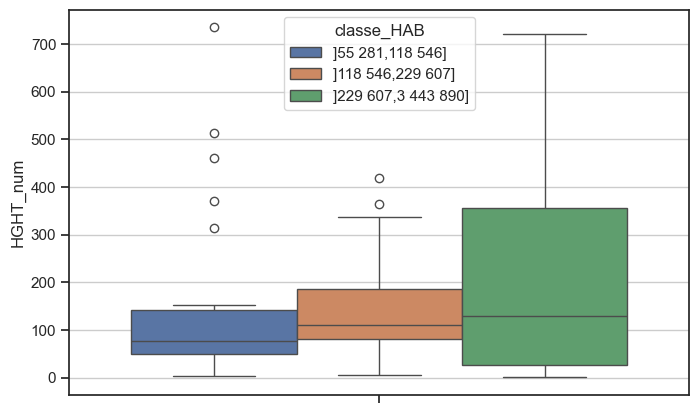

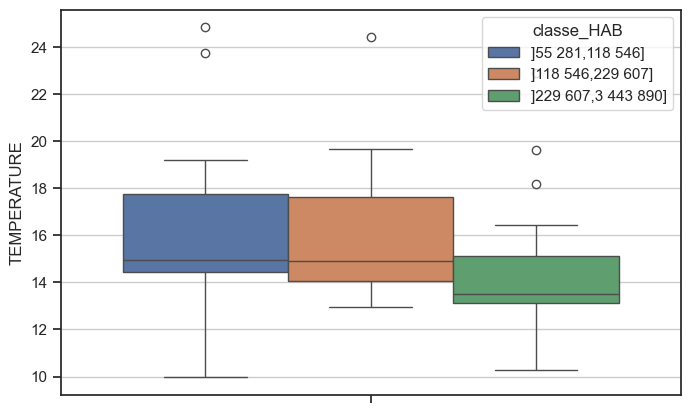

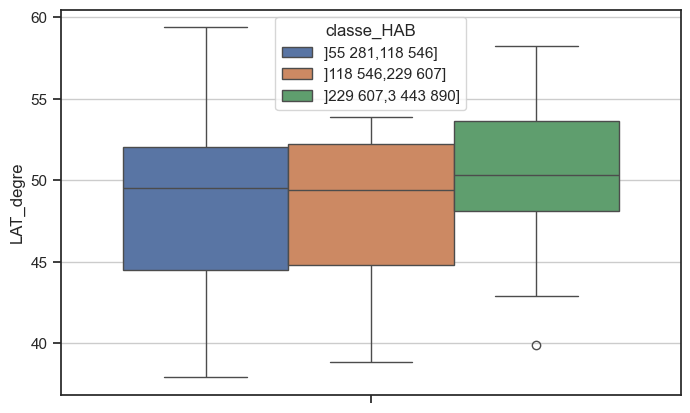

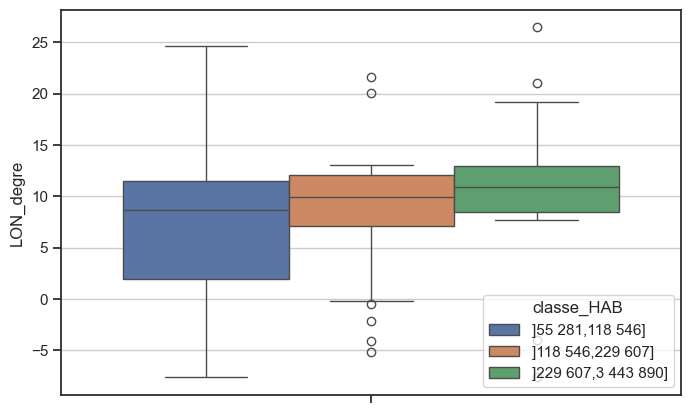

In [26]:
# Selection of quantitative variables+Citye
quant_vars = df_extract_with_classes[['classe_HAB','HGHT_num','TEMPERATURE','LAT_degre','LON_degre']]

axe_abscisse=8
axe_ordonnee=5

# Plotting boxplots for each quantitative variable with Seaborn
sns.set(style="ticks")

for var in quant_vars:
    if var!='classe_HAB':
        plt.figure(figsize=(axe_abscisse,axe_ordonnee))
        plt.grid()
        sns.boxplot(data=df_extract_with_classes, y=var, hue='classe_HAB', hue_order=order_HAB)

Analyse visuelle :

La dispersion du nombre d'habitant semble moins forte avec l'augmentation de la latitude (vers le pole nord).

La dispersion du nombre d'habitant semble moins forte avec l'augmentation de la longitude (vers l'est).

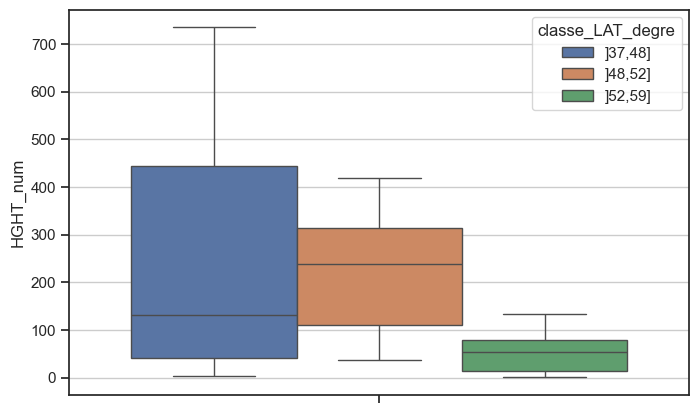

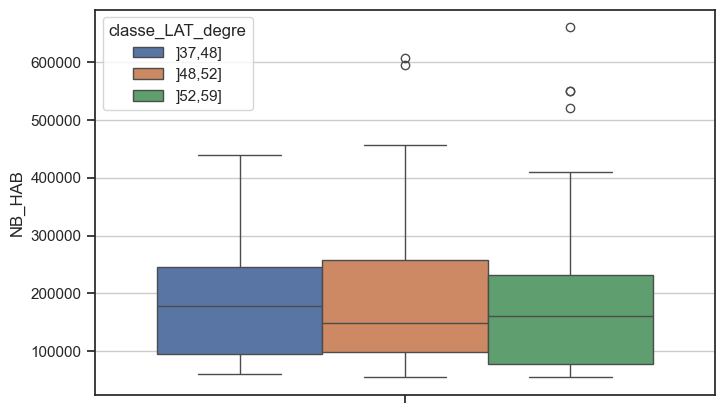

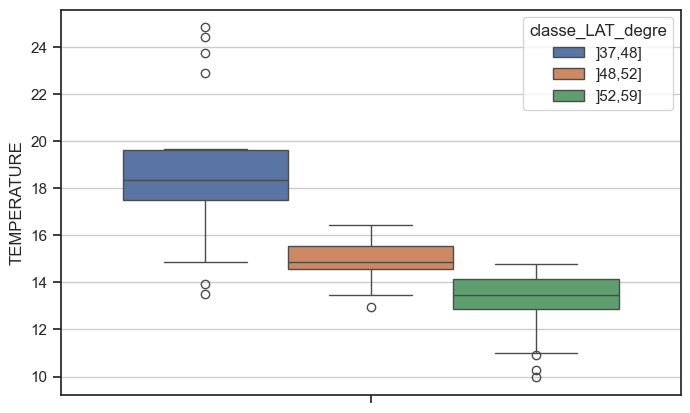

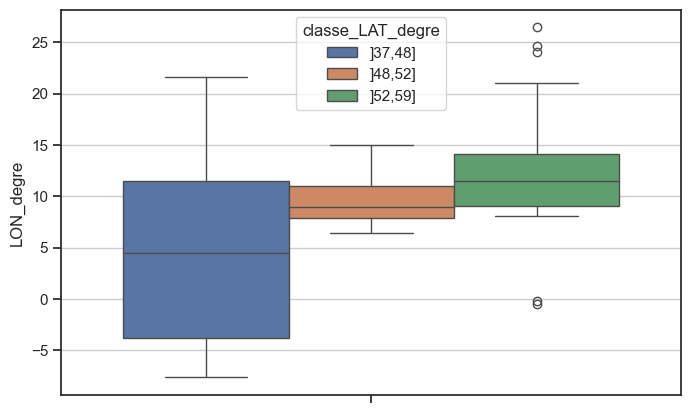

In [27]:
# Selection of quantitative variables+Citye
quant_vars = df_extract_with_classes[['classe_LAT_degre','HGHT_num','NB_HAB','TEMPERATURE','LON_degre']]

axe_abscisse=8
axe_ordonnee=5

# Plotting boxplots for each quantitative variable with Seaborn
sns.set(style="ticks")

for var in quant_vars:
    if var!='classe_LAT_degre':
        plt.figure(figsize=(axe_abscisse,axe_ordonnee))
        plt.grid()
        if var=='NB_HAB':# Zoom
            sns.boxplot(data=df_extract_with_classes.query("NB_HAB<1500000"), y=var, hue='classe_LAT_degre', hue_order=order_LAT)
        else:
            sns.boxplot(data=df_extract_with_classes, y=var, hue='classe_LAT_degre', hue_order=order_LAT)


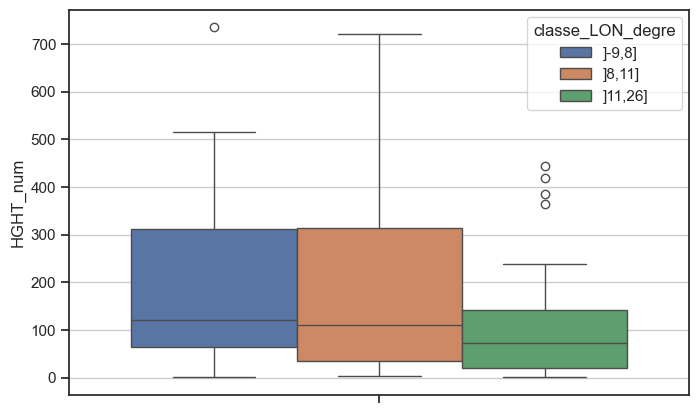

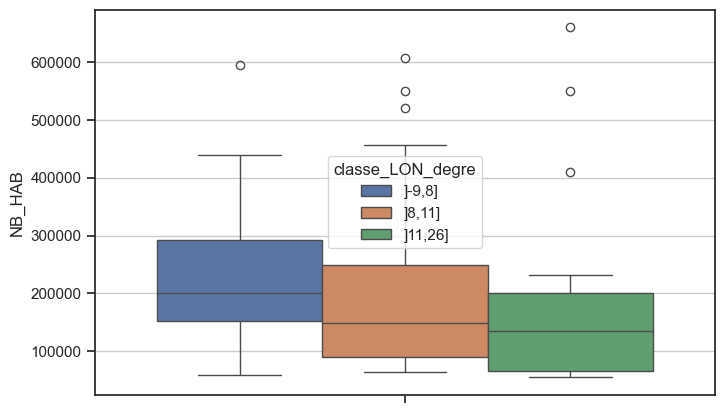

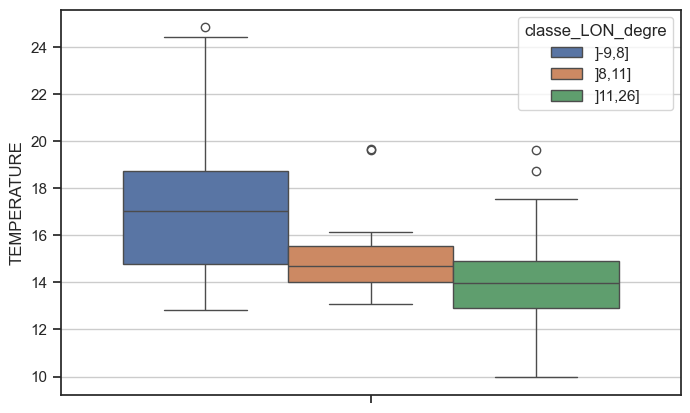

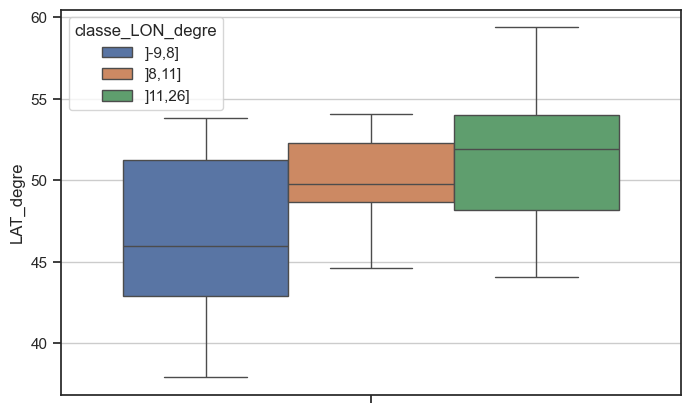

In [28]:
# Selection of quantitative variables+Citye
quant_vars = df_extract_with_classes[['classe_LON_degre','HGHT_num','NB_HAB','TEMPERATURE','LAT_degre']]

axe_abscisse=8
axe_ordonnee=5

# Plotting boxplots for each quantitative variable with Seaborn
sns.set(style="ticks")

for var in quant_vars:
    if var!='classe_LON_degre':
        plt.figure(figsize=(axe_abscisse,axe_ordonnee))
        plt.grid()
        if var=='NB_HAB':# Zoom
            sns.boxplot(data=df_extract_with_classes.query("NB_HAB<1500000"), y=var, hue='classe_LON_degre', hue_order=order_LON) #.query("NB_HAB<1500000")
        else:
            sns.boxplot(data=df_extract_with_classes, y=var, hue='classe_LON_degre', hue_order=order_LON)

# Variable qualitative et Capitale

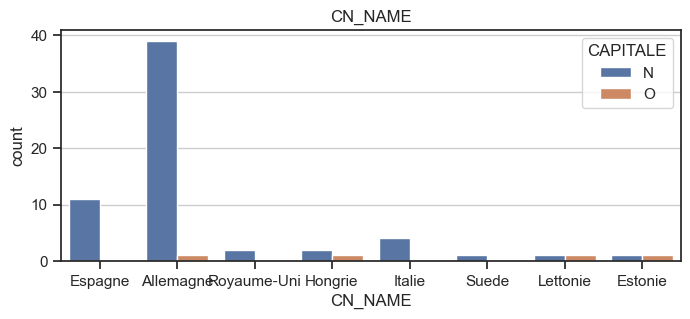

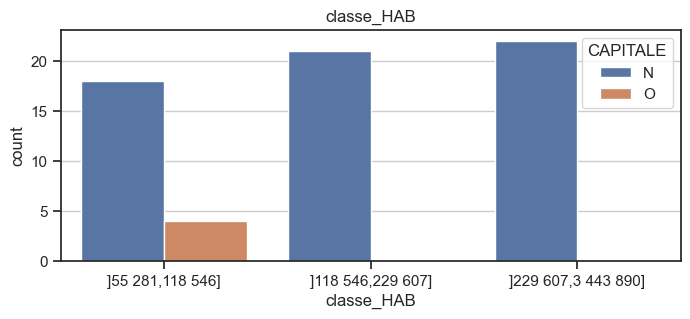

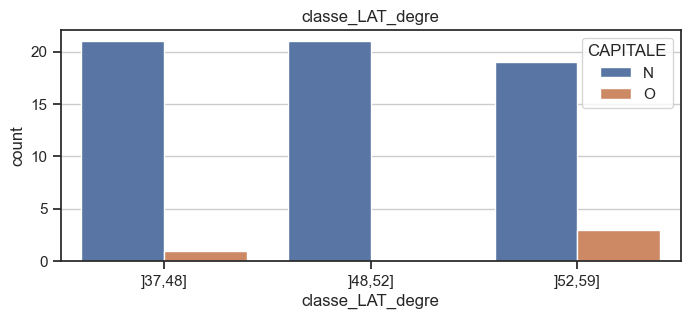

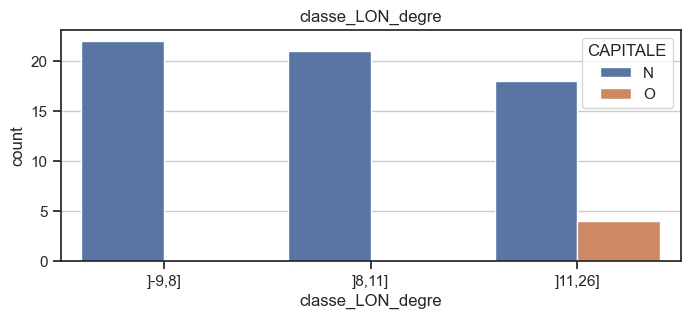

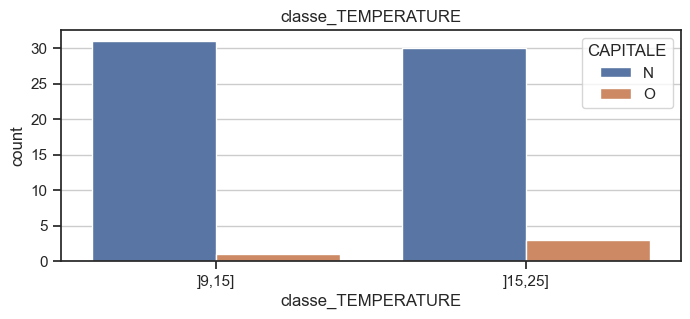

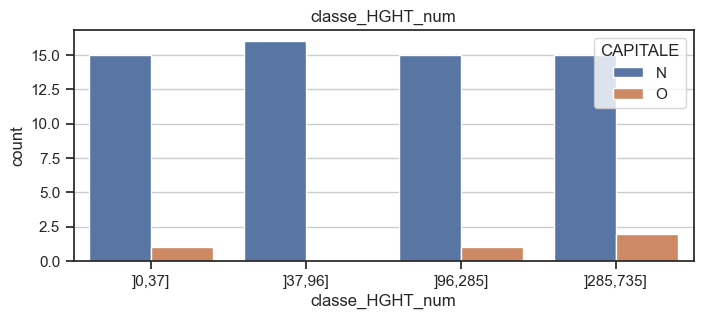

In [29]:
# Select categorical variables
cat_vars = ['CN_NAME','classe_HAB','classe_LAT_degre','classe_LON_degre','classe_TEMPERATURE','classe_HGHT_num']
#fichier_analyser_sans_pays_PL = fichier_analyser.query("CN!='DE' & CN!='ES' & CN!='PL' & CN!='RO'") ,'CAPITALE'
axe_abscisse=8;axe_ordonnee=3

# Generate a pie plot for each categorical variable
for var in cat_vars:
    #fichier_analyser[var].value_counts().plot(kind='pie', autopct='%1.1f%%')
    plt.figure(figsize=(axe_abscisse,axe_ordonnee))
    plt.grid()
    if var!='CN_NAME':
        sns.countplot(data=df_extract_with_classes, x=var,order = order_dict[var], hue='CAPITALE') #
    else:
        sns.countplot(data=df_extract_with_classes, x=var, hue='CAPITALE')
    plt.title(var)

Analyse visuelle

Les capitales ont des indicateurs de température (ou des hauteurs) moyennement élevées.

Peu de capitales ont des températures élevées.

Les capitales sont mieux réparties dans les classes de LATITUDE que les LONGITUDES et sont moyennement peuplées.

## Analyse bivariée des variables qualitatives


Il y a un lien entre une  is a link between sparsely populated cities and rising temperatures ?
There is a link between cities with medium/high population density and rising temperatures ?



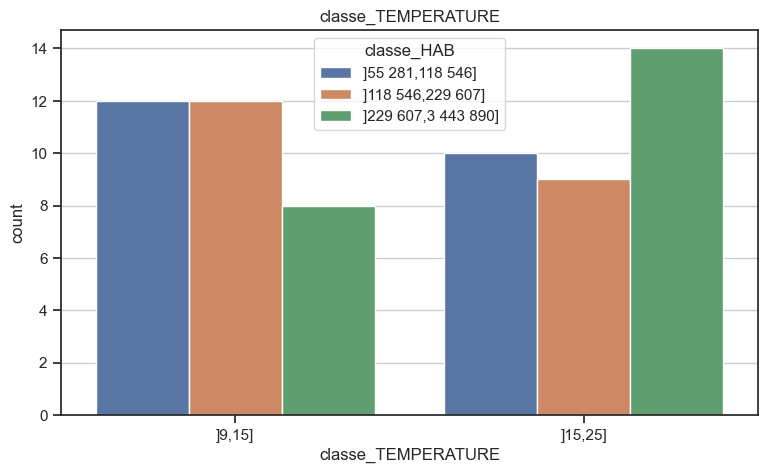

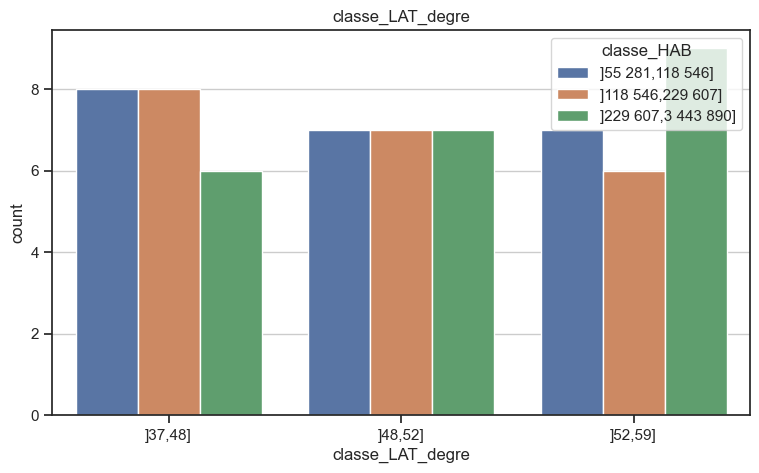

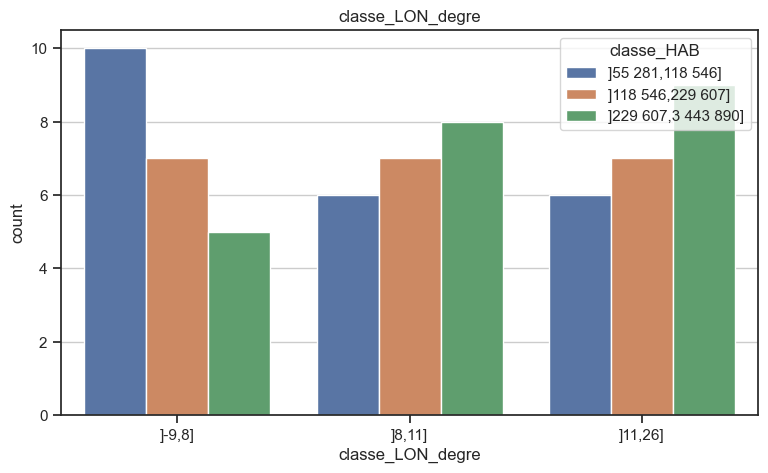

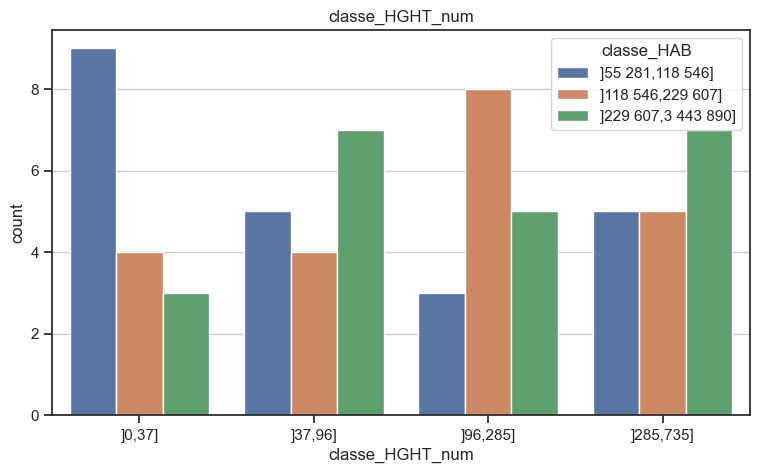

In [31]:
# Select categorical variables
cat_vars = ['classe_TEMPERATURE','classe_LAT_degre','classe_LON_degre','classe_HGHT_num']
#fichier_analyser_sans_pays_PL = fichier_analyser.query("CN!='DE' & CN!='ES' & CN!='PL' & CN!='RO'") ,'CAPITALE'
axe_abscisse=9;axe_ordonnee=5

# Generate a pie plot for each categorical variable
for var in cat_vars:
    #
    plt.figure(figsize=(axe_abscisse,axe_ordonnee))
    plt.grid()
    sns.countplot(data=df_extract_with_classes, x=var, order = order_dict[var],hue='classe_HAB', hue_order=order_dict['classe_HAB']) #    
    plt.title(var)
    #plt.axis('equal')
    #plt.show()
    
print("")
print("Il y a un lien entre une  is a link between sparsely populated cities and rising temperatures ?")
print("There is a link between cities with medium/high population density and rising temperatures ?")
print("")

## Test du Chi-2

Condition d'utilisation :

Les variables sont qualitatives.

Test non paramétric.

Hypothèses :

H0 : Variables indépendantes 

H1 : Variables dépendantes


In [32]:
#from scipy.stats import chi2_contingency
# Create a contingency table
contingency_table = pd.crosstab(df_extract_with_classes['classe_TEMPERATURE'], df_extract_with_classes['classe_HAB'])
print('Il y a des cellules comportant des données <5 ?')
print("")
print("Table contingence :")
contingency_table

Il y a des cellules comportant des données <5 ?

Table contingence :


classe_HAB,"]229 607,3 443 890]","]118 546,229 607]","]55 281,118 546]"
classe_TEMPERATURE,,,
"]15,25]",14,9,10
"]9,15]",8,12,12


In [33]:
#from scipy.stats import chi2_contingency
Khi2_obs, p_value, ddl, effectif_theorique = chi2_contingency(contingency_table)
print("P-value",p_value)
print('')
print("Variables : Température vs Habitant")
print('')
if p_value<0.05:
    print("La p_valeur est inférieure à 5%, je rejette H0, les variables sont dépendantes.")
else:
    print("La p_valeur est supérieure à 5%, les variables sont indépendantes.")

P-value 0.327604416572225

Variables : Température vs Habitant

La p_valeur est supérieure à 5%, les variables sont indépendantes.


#-----------------------------------------

In [34]:
#from scipy.stats import chi2_contingency
# Create a contingency table
contingency_table = pd.crosstab(df_extract_with_classes['classe_LAT_degre'], df_extract_with_classes['classe_HAB'])
print('Il y a des cellules comportant des données <5 ?')
print("")
print("Table contingence :")
contingency_table

Il y a des cellules comportant des données <5 ?

Table contingence :


classe_HAB,"]229 607,3 443 890]","]118 546,229 607]","]55 281,118 546]"
classe_LAT_degre,,,
"]37,48]",6,8,8
"]48,52]",7,7,7
"]52,59]",9,6,7


In [35]:
Khi2_obs, p_value, ddl, effectif_theorique = chi2_contingency(contingency_table)
print("P-value",p_value)
print('')
print("Variables : Latitude vs Habitant")
print('')
if p_value<0.05:
    print("La p_valeur est inférieure à 5%, je rejette H0, les variables sont dépendantes.")
else:
    print("La p_valeur est supérieure à 5%, les variables sont indépendantes.")

P-value 0.9146393904039474

Variables : Latitude vs Habitant

La p_valeur est supérieure à 5%, les variables sont indépendantes.


#-----------------------------------------

In [36]:
contingency_table = pd.crosstab(df_extract_with_classes['classe_LON_degre'], df_extract_with_classes['classe_HAB'])
print('Il y a des cellules comportant des données <5 ?')
print("")
print("Table contingence :")
contingency_table

Il y a des cellules comportant des données <5 ?

Table contingence :


classe_HAB,"]229 607,3 443 890]","]118 546,229 607]","]55 281,118 546]"
classe_LON_degre,,,
"]-9,8]",5,7,10
"]8,11]",8,7,6
"]11,26]",9,7,6


In [37]:
Khi2_obs, p_value, ddl, effectif_theorique = chi2_contingency(contingency_table)
print("P-value",p_value)
print('')
print("Variables : Longitude vs Habitant")
print('')
if p_value<0.05:
    print("La p_valeur est inférieure à 5%, je rejette H0, les variables sont dépendantes.")
else:
    print("La p_valeur est supérieure à 5%, les variables sont indépendantes.")

P-value 0.6304828272368338

Variables : Longitude vs Habitant

La p_valeur est supérieure à 5%, les variables sont indépendantes.


#-----------------------------------------

# Quantitative vs Quantitative

## Test de corrélation de Pearson

Variable 1 : Temperature

Variable 2 : Latitude (degré)

Condition d'utilisation

Les variables sont qualitatives et sont continues

La relation est linéaire.

Les variables sont issues de distribution normale.

## Test Shapiro Wilk
Identifie si distribution normale

H0 : Distribution normale

H1 : Distribution qui n'est pas normale

In [38]:
list_VAR=['TEMPERATURE', 'LAT_degre']

for var in list_VAR:
    _, p_value = shapiro(df_extract_with_classes[var])
    if p_value<0.05:
        print("La p_valeur est inférieure à 5%, je rejette H0, la distribution n'est pas normale.")
    else:
        print("La p_valeur est supérieure à 5%, la distribution est normale.")
        
    print(f"P-valeur de la normalité (Shapiro-Wilk) pour {var}:", p_value)
    print("")

La p_valeur est inférieure à 5%, je rejette H0, la distribution n'est pas normale.
P-valeur de la normalité (Shapiro-Wilk) pour TEMPERATURE: 0.0001724349713185802

La p_valeur est supérieure à 5%, la distribution est normale.
P-valeur de la normalité (Shapiro-Wilk) pour LAT_degre: 0.09204880148172379



In [39]:
print("les conditions d'utilisation de la corrélation de Pearson non respectées !")

les conditions d'utilisation de la corrélation de Pearson non respectées !


## La correlation de Spearman 

Condition d'utilisation :

Les variables sont quantitatives.

Les varaibles ne sont pas normalement distribuées.

La relation est monotone.

H0 : pas de correlation monotone.

H1 : Corrélation monotone

In [40]:
correlation,pvalue=spearmanr(df_extract_with_classes[list_VAR[0]], df_extract_with_classes[list_VAR[1]])
print("Spearman :",pvalue)
if pvalue<0.05:
    print("Corrélation monotone entre",list_VAR)
else:
    print("No corrélation monotone",list_VAR)
if correlation>0:
    print("Correlation positive ",correlation)
else:
    print("Correlation negative ",correlation)

Spearman : 3.831808563864504e-23
Corrélation monotone entre ['TEMPERATURE', 'LAT_degre']
Correlation negative  -0.8898164335664336


## Le taux de correlation de Kendal

Mesure la corrélation de rang entre de 2 variables

Non parametric



In [41]:
# Calcul de la corrélation de kendall

correlation,pvalue=kendalltau(df_extract_with_classes[list_VAR[0]], df_extract_with_classes[list_VAR[1]])
print("Kendall")
if pvalue<0.05:
    print("Correlation monotone ",list_VAR)
else:
    print("No correlation monotone",list_VAR)
if correlation>0:
    print("Correlation positive ",correlation)
else:
    print("Correlation negative ",correlation)

Kendall
Correlation monotone  ['TEMPERATURE', 'LAT_degre']
Correlation negative  -0.7355769230769231


# Analyse graphique

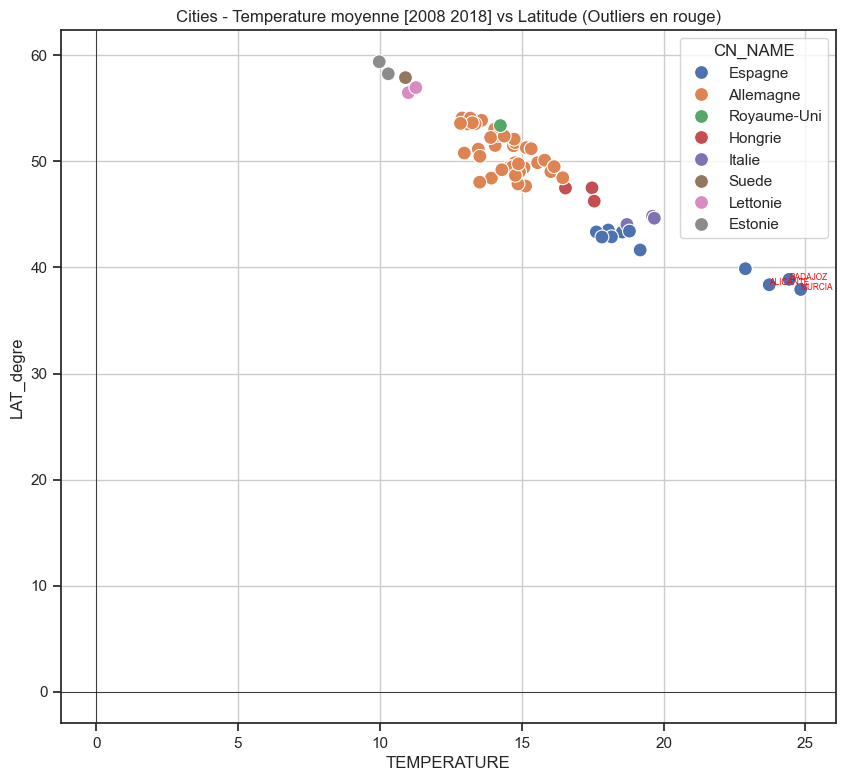

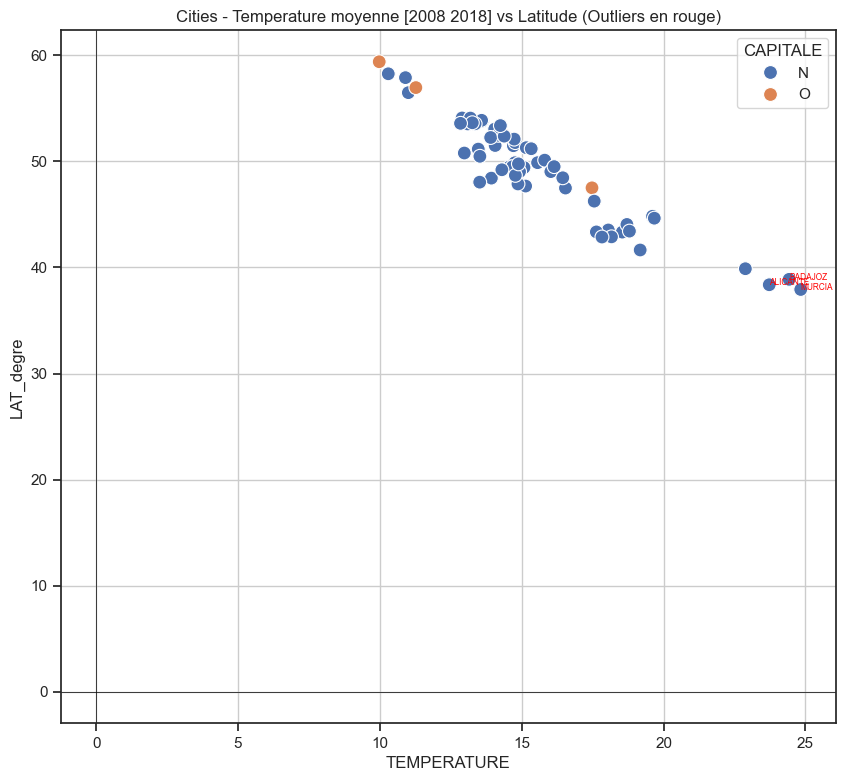

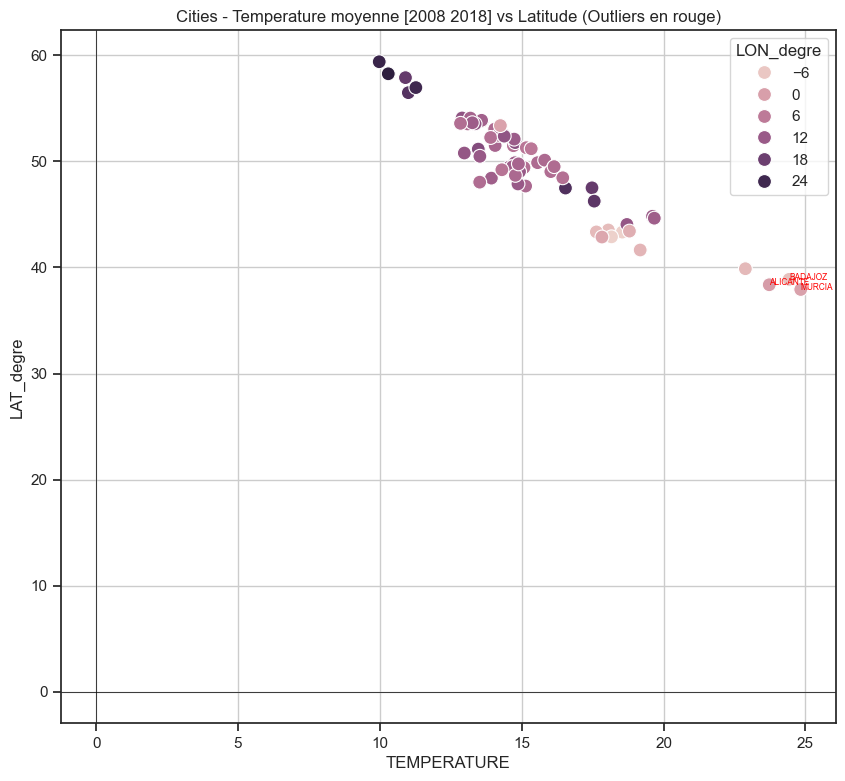

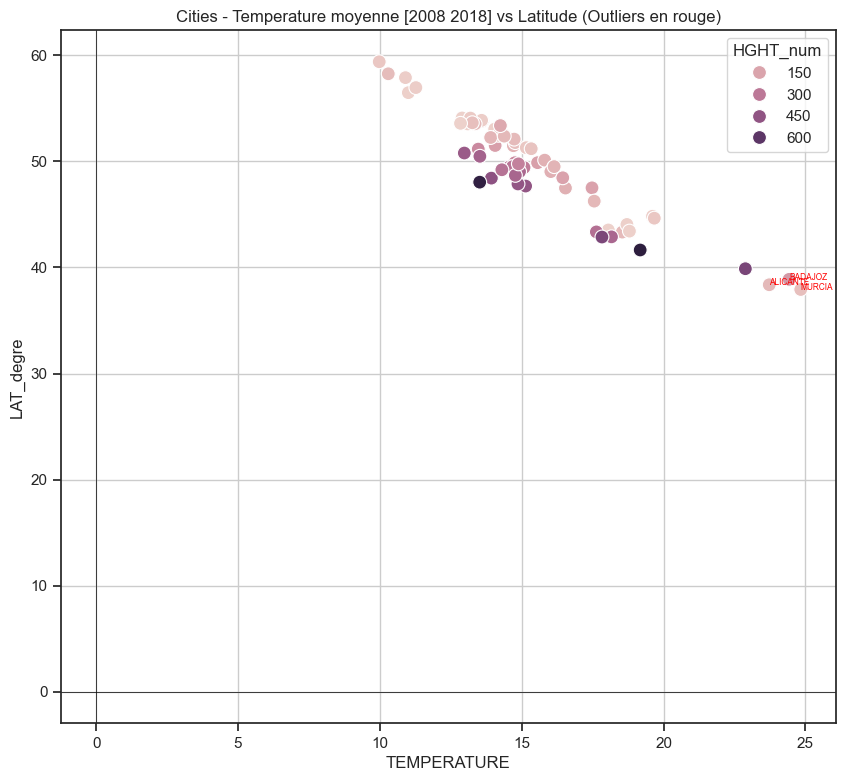

In [42]:
df=df_extract_with_classes
delta= 1.5*(df[list_VAR[0]].quantile(0.75) - df[list_VAR[0]].quantile(0.25))
df_outlier=df[(df[list_VAR[0]] > (df[list_VAR[0]].quantile(0.75) + delta)) | (df[list_VAR[0]] < (df[list_VAR[0]].quantile(0.25) - delta))]

for var in ['CN_NAME','CAPITALE','LON_degre','HGHT_num']:

    plt.figure(figsize=(10, 9))
    ax=sns.scatterplot(data=df, x=list_VAR[0], y=list_VAR[1],s=100, hue=var,legend=True)
        # Forcer l'origine à être visible
    ax.axhline(0, color='black', linewidth=0.5)  # Ligne horizontale pour l'axe des x
    ax.axvline(0, color='black', linewidth=0.5)  # Ligne verticale pour l'axe des y

    # Ajoutez les annotations
    for i, outlier in df_outlier.iterrows():
        ax.annotate(str(outlier["CITY"]), xy=(outlier[list_VAR[0]], outlier[list_VAR[1]]), color="red", fontsize=6)
        
    plt.xlabel(list_VAR[0])
    plt.grid()
    plt.title("Cities - Temperature moyenne [2008 2018] vs Latitude (Outliers en rouge)")
    plt.show()